In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.GRU_SingleStep_v6 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-11-15 13:53:00.684212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 13:53:00.684903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 13:53:00.759526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 13:53:00.759817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 13:53:00.760139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')
    
    # autoencoder directory
    ae_idx = '020'
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_008'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    dir_name_ae = params_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    

    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        fl = np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True)
        normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    fl = np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True)
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_020
data_dir_idx: 004
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

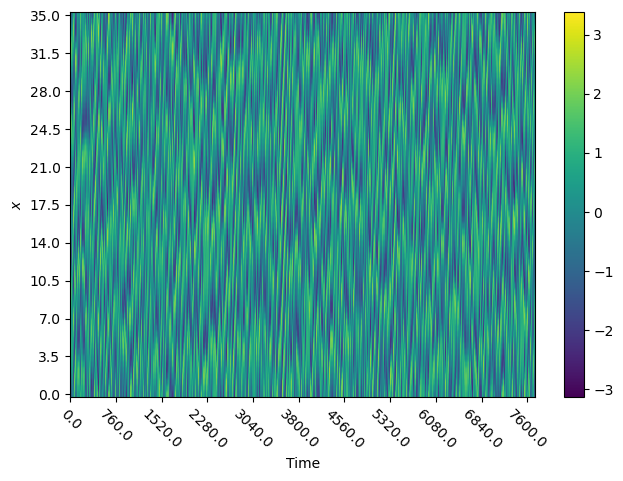

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# delaing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

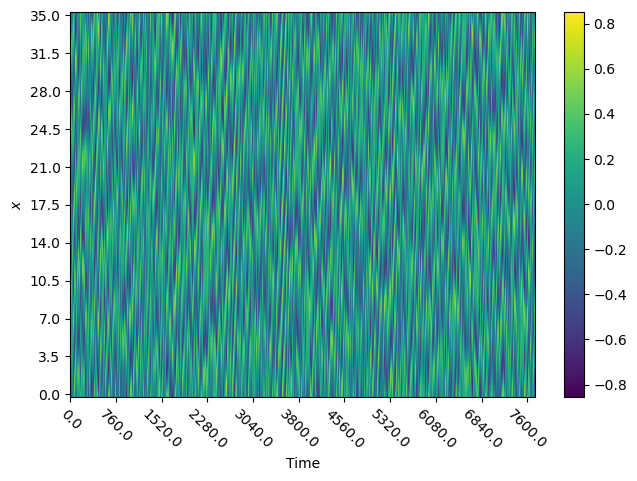

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [18]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae_og = dir_name_ae
#     dir_name_ae_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_'+ae_idx
#     dir_name_ae = dir_name_ae_temp

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

# if colab_flag == False:
#     dir_name_ae = dir_name_ae_og

In [19]:
ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [20]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)
num_latent_states = latent_states_all.shape[1]

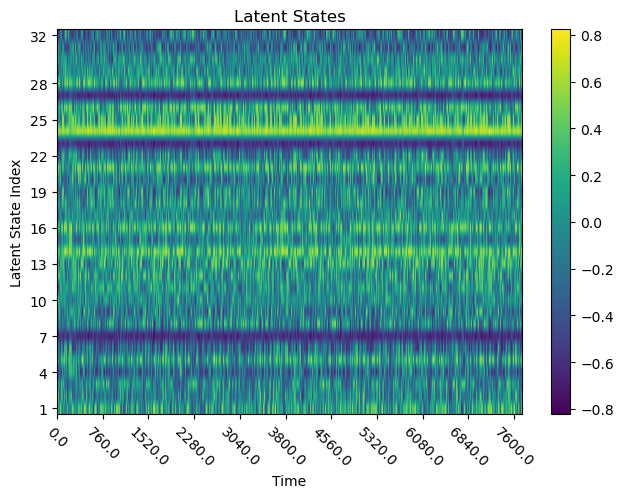

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [23]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    stddev_multiplier = 3
    skip_intermediate = 1/4
    noise_type = 'normal'
    normalization_type = 'stddev' # can be 'minmax' or 'stddev', if it is
                                  # 'minmax' then stddev_multiplier has no effect
    dense_layer_act_func = ['relu', 'linear']
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_ae':dir_name_ae,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)

In [26]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 0.025

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [27]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [28]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [num_train]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [num_train]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [num_val]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [num_train]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [cum_samples-num_train-num_val]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [cum_samples-num_train-num_val]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
idx = np.arange(0, training_data_rnn_input.shape[0])
np.random.shuffle(idx)
training_data_rnn_input = training_data_rnn_input[idx]
training_data_rnn_output = training_data_rnn_output[idx]

idx = np.arange(0, val_data_rnn_input.shape[0])
np.random.shuffle(idx)
val_data_rnn_input = val_data_rnn_input[idx]
val_data_rnn_output = val_data_rnn_output[idx]

idx = np.arange(0, testing_data_rnn_input.shape[0])
np.random.shuffle(idx)
testing_data_rnn_input = testing_data_rnn_input[idx]
testing_data_rnn_output = testing_data_rnn_output[idx]

del(idx)

In [29]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [2**8]*1
#     timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output
        )
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.40322953
stddev : 0.010080738365650177


In [30]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [31]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 0.1524 - tot_time: 0h 1m 36.1s

Epoch 1: val_loss improved from inf to 0.11786, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 96s 5s/step - loss: 0.1524 - val_loss: 0.1179
Epoch 2/1000
5/5 [==============================] - ETA: 0s - loss: 0.1013 - tot_time: 0h 1m 37.5s

Epoch 2: val_loss improved from 0.11786 to 0.08581, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Docu

Epoch 18/1000
5/5 [==============================] - ETA: 0s - loss: 0.0420 - tot_time: 0h 1m 59.8s

Epoch 18: val_loss improved from 0.04262 to 0.04146, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 277ms/step - loss: 0.0420 - val_loss: 0.0415
Epoch 19/1000
5/5 [==============================] - ETA: 0s - loss: 0.0409 - tot_time: 0h 2m 1.2s

Epoch 19: val_loss improved from 0.04146 to 0.04032, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 295ms/step - loss: 0.0409 - val_loss: 0.0403
Epoch 20/1000
5/5 [==============================] - ETA: 0s - loss: 0.0398 -

Epoch 36/1000
5/5 [==============================] - ETA: 0s - loss: 0.0296 - tot_time: 0h 2m 25.0s

Epoch 36: val_loss improved from 0.02958 to 0.02914, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 283ms/step - loss: 0.0296 - val_loss: 0.0291
Epoch 37/1000
5/5 [==============================] - ETA: 0s - loss: 0.0290 - tot_time: 0h 2m 26.4s

Epoch 37: val_loss improved from 0.02914 to 0.02876, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 287ms/step - loss: 0.0290 - val_loss: 0.0288
Epoch 38/1000
5/5 [==============================] - ETA: 0s - loss: 0.0285 

Epoch 54/1000
5/5 [==============================] - ETA: 0s - loss: 0.0230 - tot_time: 0h 2m 49.9s

Epoch 54: val_loss improved from 0.02315 to 0.02282, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 292ms/step - loss: 0.0230 - val_loss: 0.0228
Epoch 55/1000
5/5 [==============================] - ETA: 0s - loss: 0.0227 - tot_time: 0h 2m 51.3s

Epoch 55: val_loss improved from 0.02282 to 0.02254, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 290ms/step - loss: 0.0227 - val_loss: 0.0225
Epoch 56/1000
5/5 [==============================] - ETA: 0s - loss: 0.0224 

Epoch 72/1000
5/5 [==============================] - ETA: 0s - loss: 0.0191 - tot_time: 0h 3m 14.7s

Epoch 72: val_loss improved from 0.01931 to 0.01889, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 293ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 73/1000
5/5 [==============================] - ETA: 0s - loss: 0.0188 - tot_time: 0h 3m 16.0s

Epoch 73: val_loss improved from 0.01889 to 0.01871, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 277ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 74/1000
5/5 [==============================] - ETA: 0s - loss: 0.0185 

Epoch 91/1000
5/5 [==============================] - ETA: 0s - loss: 0.0158 - tot_time: 0h 3m 40.4s

Epoch 91: val_loss improved from 0.01599 to 0.01579, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 290ms/step - loss: 0.0158 - val_loss: 0.0158
Epoch 92/1000
5/5 [==============================] - ETA: 0s - loss: 0.0157 - tot_time: 0h 3m 41.8s

Epoch 92: val_loss improved from 0.01579 to 0.01560, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 283ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 93/1000
5/5 [==============================] - ETA: 0s - loss: 0.0155 

5/5 [==============================] - ETA: 0s - loss: 0.0136 - tot_time: 0h 4m 5.3s

Epoch 109: val_loss improved from 0.01372 to 0.01355, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 297ms/step - loss: 0.0136 - val_loss: 0.0135
Epoch 110/1000
5/5 [==============================] - ETA: 0s - loss: 0.0134 - tot_time: 0h 4m 6.7s

Epoch 110: val_loss improved from 0.01355 to 0.01341, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 297ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 111/1000
5/5 [==============================] - ETA: 0s - loss: 0.0133 - tot_time: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 281ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 128/1000
5/5 [==============================] - ETA: 0s - loss: 0.0118 - tot_time: 0h 4m 31.7s

Epoch 128: val_loss did not improve from 0.01184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 269ms/step - loss: 0.0118 - val_loss: 0.0120
Epoch 129/1000
5/5 [==============================] - ETA: 0s - loss: 0.0117 - tot_time: 0h 4m 33.0s

Epoch 129: val_loss improved from 0.01184 to 0.01169, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 287ms/step

Epoch 146/1000
5/5 [==============================] - ETA: 0s - loss: 0.0102 - tot_time: 0h 4m 56.4s

Epoch 146: val_loss did not improve from 0.01032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 267ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 147/1000
5/5 [==============================] - ETA: 0s - loss: 0.0103 - tot_time: 0h 4m 57.7s

Epoch 147: val_loss improved from 0.01032 to 0.01022, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 287ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 148/1000
5/5 [==============================] - ETA: 0s - loss: 0.0101 - tot_time: 0h 4m 59.1s

Epoch 148: val_loss improved from 0.01022 to 0.01016, saving model to /ho

Epoch 165/1000
5/5 [==============================] - ETA: 0s - loss: 0.0090 - tot_time: 0h 5m 22.4s

Epoch 165: val_loss improved from 0.00921 to 0.00906, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 284ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 166/1000
5/5 [==============================] - ETA: 0s - loss: 0.0089 - tot_time: 0h 5m 23.8s

Epoch 166: val_loss improved from 0.00906 to 0.00896, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 308ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 167/1000
5/5 [==============================] - ETA: 0s - loss: 0.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 282ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 184/1000
5/5 [==============================] - ETA: 0s - loss: 0.0079 - tot_time: 0h 5m 48.6s

Epoch 184: val_loss improved from 0.00801 to 0.00796, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 284ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 185/1000
5/5 [==============================] - ETA: 0s - loss: 0.0078 - tot_time: 0h 5m 50.0s

Epoch 185: val_loss improved from 0.00796 to 0.00790, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/sav

Epoch 202/1000
5/5 [==============================] - ETA: 0s - loss: 0.0070 - tot_time: 0h 6m 13.1s

Epoch 202: val_loss improved from 0.00716 to 0.00711, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 276ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 203/1000
5/5 [==============================] - ETA: 0s - loss: 0.0070 - tot_time: 0h 6m 14.4s

Epoch 203: val_loss improved from 0.00711 to 0.00709, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 283ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 204/1000
5/5 [==============================] - ETA: 0s - loss: 0.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 292ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 221/1000
5/5 [==============================] - ETA: 0s - loss: 0.0063 - tot_time: 0h 6m 39.3s

Epoch 221: val_loss did not improve from 0.00641
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 271ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 222/1000
5/5 [==============================] - ETA: 0s - loss: 0.0063 - tot_time: 0h 6m 40.5s

Epoch 222: val_loss did not improve from 0.00641
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 267ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 223/1000
5/5 [==============================] - ETA: 0s - loss

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 306ms/step - loss: 0.0056 - val_loss: 0.0058
Epoch 240/1000
5/5 [==============================] - ETA: 0s - loss: 0.0056 - tot_time: 0h 7m 5.3s

Epoch 240: val_loss improved from 0.00576 to 0.00574, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 280ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 241/1000
5/5 [==============================] - ETA: 0s - loss: 0.0056 - tot_time: 0h 7m 6.7s

Epoch 241: val_loss improved from 0.00574 to 0.00570, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved

Epoch 258/1000
5/5 [==============================] - ETA: 0s - loss: 0.0051 - tot_time: 0h 7m 30.1s

Epoch 258: val_loss did not improve from 0.00527
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 266ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 259/1000
5/5 [==============================] - ETA: 0s - loss: 0.0051 - tot_time: 0h 7m 31.5s

Epoch 259: val_loss improved from 0.00527 to 0.00522, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 291ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 260/1000
5/5 [==============================] - ETA: 0s - loss: 0.0050 - tot_time: 0h 7m 32.9s

Epoch 260: val_loss improved from 0.00522 to 0.00516, saving model to /ho

Epoch 277/1000
5/5 [==============================] - ETA: 0s - loss: 0.0046 - tot_time: 0h 7m 55.9s

Epoch 277: val_loss improved from 0.00477 to 0.00474, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 281ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 278/1000
5/5 [==============================] - ETA: 0s - loss: 0.0046 - tot_time: 0h 7m 57.2s

Epoch 278: val_loss improved from 0.00474 to 0.00471, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 281ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 279/1000
5/5 [==============================] - ETA: 0s - loss: 0.

5/5 [==============================] - ETA: 0s - loss: 0.0042 - tot_time: 0h 8m 21.8s

Epoch 296: val_loss did not improve from 0.00438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 263ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 297/1000
5/5 [==============================] - ETA: 0s - loss: 0.0042 - tot_time: 0h 8m 23.1s

Epoch 297: val_loss did not improve from 0.00438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 265ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 298/1000
5/5 [==============================] - ETA: 0s - loss: 0.0042 - tot_time: 0h 8m 24.4s

Epoch 298: val_loss did not improve from 0.00438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 274ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 316/1000
5/5 [==============================] - ETA: 0s - loss: 0.0038 - tot_time: 0h 8m 48.8s

Epoch 316: val_loss improved from 0.00400 to 0.00397, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 281ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 317/1000
5/5 [==============================] - ETA: 0s - loss: 0.0038 - tot_time: 0h 8m 50.2s

Epoch 317: val_loss did not improve from 0.00397
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 272ms/step

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 290ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 336/1000
5/5 [==============================] - ETA: 0s - loss: 0.0036 - tot_time: 0h 9m 15.8s

Epoch 336: val_loss did not improve from 0.00375
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 265ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 337/1000
5/5 [==============================] - ETA: 0s - loss: 0.0036 - tot_time: 0h 9m 17.2s

Epoch 337: val_loss did not improve from 0.00375
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 281ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 338/1000
5/5 [==============================] - ETA: 0s - loss

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 283ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 357/1000
5/5 [==============================] - ETA: 0s - loss: 0.0033 - tot_time: 0h 9m 43.9s

Epoch 357: val_loss improved from 0.00346 to 0.00344, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 276ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 358/1000
5/5 [==============================] - ETA: 0s - loss: 0.0032 - tot_time: 0h 9m 45.3s

Epoch 358: val_loss improved from 0.00344 to 0.00342, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/sav

Epoch 377/1000
5/5 [==============================] - ETA: 0s - loss: 0.0030 - tot_time: 0h 10m 10.7s

Epoch 377: val_loss improved from 0.00327 to 0.00325, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 298ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 378/1000
5/5 [==============================] - ETA: 0s - loss: 0.0030 - tot_time: 0h 10m 12.1s

Epoch 378: val_loss improved from 0.00325 to 0.00323, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 277ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 379/1000
5/5 [==============================] - ETA: 0s - loss: 

5/5 [==============================] - ETA: 0s - loss: 0.0029 - tot_time: 0h 10m 37.7s

Epoch 397: val_loss improved from 0.00308 to 0.00306, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 287ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 398/1000
5/5 [==============================] - ETA: 0s - loss: 0.0029 - tot_time: 0h 10m 39.1s

Epoch 398: val_loss did not improve from 0.00306
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 274ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 399/1000
5/5 [==============================] - ETA: 0s - loss: 0.0029 - tot_time: 0h 10m 40.5s

Epoch 399: val_loss improved from 0.00306 to 0.00304, saving model to /home/rkaushik/

5/5 [==============================] - ETA: 0s - loss: 0.0027 - tot_time: 0h 11m 4.8s

Epoch 417: val_loss improved from 0.00293 to 0.00292, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 301ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 418/1000
5/5 [==============================] - ETA: 0s - loss: 0.0027 - tot_time: 0h 11m 6.3s

Epoch 418: val_loss improved from 0.00292 to 0.00292, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 285ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 419/1000
5/5 [==============================] - ETA: 0s - loss: 0.0027 - tot_time

Epoch 437/1000
5/5 [==============================] - ETA: 0s - loss: 0.0026 - tot_time: 0h 11m 32.1s

Epoch 437: val_loss did not improve from 0.00278
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 272ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 438/1000
5/5 [==============================] - ETA: 0s - loss: 0.0026 - tot_time: 0h 11m 33.5s

Epoch 438: val_loss did not improve from 0.00278
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 278ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 439/1000
5/5 [==============================] - ETA: 0s - loss: 0.0027 - tot_time: 0h 11m 34.8s

Epoch 439: val_loss did not improve from 0.00278
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5

5/5 [==============================] - ETA: 0s - loss: 0.0025 - tot_time: 0h 12m 0.3s

Epoch 458: val_loss did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 269ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 459/1000
5/5 [==============================] - ETA: 0s - loss: 0.0025 - tot_time: 0h 12m 1.6s

Epoch 459: val_loss did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 268ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 460/1000
5/5 [==============================] - ETA: 0s - loss: 0.0024 - tot_time: 0h 12m 3.0s

Epoch 460: val_loss improved from 0.00269 to 0.00266, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaus

Epoch 480/1000
5/5 [==============================] - ETA: 0s - loss: 0.0024 - tot_time: 0h 12m 29.7s

Epoch 480: val_loss improved from 0.00261 to 0.00259, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 274ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 481/1000
5/5 [==============================] - ETA: 0s - loss: 0.0024 - tot_time: 0h 12m 31.1s

Epoch 481: val_loss did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 265ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 482/1000
5/5 [==============================] - ETA: 0s - loss: 0.0024 - tot_time: 0h 12m 32.4s

Epoch 482: val_loss did not improve from 0.00259
 - saving loss histor

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 272ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 501/1000
5/5 [==============================] - ETA: 0s - loss: 0.0023 - tot_time: 0h 12m 57.9s

Epoch 501: val_loss did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 263ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 502/1000
5/5 [==============================] - ETA: 0s - loss: 0.0023 - tot_time: 0h 12m 59.2s

Epoch 502: val_loss did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 262ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 503/1000
5/5 [==============================] - ETA: 0s - lo

Epoch 523/1000
5/5 [==============================] - ETA: 0s - loss: 0.0022 - tot_time: 0h 13m 27.3s

Epoch 523: val_loss did not improve from 0.00249
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 270ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 524/1000
5/5 [==============================] - ETA: 0s - loss: 0.0022 - tot_time: 0h 13m 28.6s

Epoch 524: val_loss improved from 0.00249 to 0.00245, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 282ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 525/1000
5/5 [==============================] - ETA: 0s - loss: 0.0022 - tot_time: 0h 13m 30.0s

Epoch 525: val_loss did not improve from 0.00245
 - saving loss histor

5/5 [==============================] - ETA: 0s - loss: 0.0022 - tot_time: 0h 13m 55.3s

Epoch 544: val_loss improved from 0.00244 to 0.00243, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 280ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 545/1000
5/5 [==============================] - ETA: 0s - loss: 0.0022 - tot_time: 0h 13m 56.8s

Epoch 545: val_loss did not improve from 0.00243
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 287ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 546/1000
5/5 [==============================] - ETA: 0s - loss: 0.0022 - tot_time: 0h 13m 58.1s

Epoch 546: val_loss did not improve from 0.00243
 - saving loss histories at /home/rk

Epoch 566/1000
5/5 [==============================] - ETA: 0s - loss: 0.0021 - tot_time: 0h 14m 24.8s

Epoch 566: val_loss did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 268ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 567/1000
5/5 [==============================] - ETA: 0s - loss: 0.0021 - tot_time: 0h 14m 26.2s

Epoch 567: val_loss did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 273ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 568/1000
5/5 [==============================] - ETA: 0s - loss: 0.0021 - tot_time: 0h 14m 27.4s

Epoch 568: val_loss did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5

Epoch 588/1000
5/5 [==============================] - ETA: 0s - loss: 0.0022 - tot_time: 0h 14m 53.8s

Epoch 588: val_loss did not improve from 0.00235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 287ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 589/1000
5/5 [==============================] - ETA: 0s - loss: 0.0021 - tot_time: 0h 14m 55.1s

Epoch 589: val_loss did not improve from 0.00235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 269ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 590/1000
5/5 [==============================] - ETA: 0s - loss: 0.0021 - tot_time: 0h 14m 56.4s

Epoch 590: val_loss did not improve from 0.00235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5

Epoch 610/1000
5/5 [==============================] - ETA: 0s - loss: 0.0021 - tot_time: 0h 15m 22.9s

Epoch 610: val_loss did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 262ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 611/1000
5/5 [==============================] - ETA: 0s - loss: 0.0021 - tot_time: 0h 15m 24.2s

Epoch 611: val_loss did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 273ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 612/1000
5/5 [==============================] - ETA: 0s - loss: 0.0021 - tot_time: 0h 15m 25.5s

Epoch 612: val_loss did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5

5/5 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 15m 51.9s

Epoch 632: val_loss did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 282ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 633/1000
5/5 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 15m 53.3s

Epoch 633: val_loss improved from 0.00232 to 0.00232, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 286ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 634/1000
5/5 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 15m 54.6s

Epoch 634: val_loss improved from 0.00232 to 0.00231, saving model to /home/rkaushik/

Epoch 653/1000
5/5 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 16m 20.1s

Epoch 653: val_loss did not improve from 0.00229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 273ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 654/1000
5/5 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 16m 21.4s

Epoch 654: val_loss did not improve from 0.00229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 259ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 655/1000
5/5 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 16m 22.7s

Epoch 655: val_loss did not improve from 0.00229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5

5/5 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 16m 49.3s

Epoch 675: val_loss did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 296ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 676/1000
5/5 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 16m 50.7s

Epoch 676: val_loss did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 274ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 677/1000
5/5 [==============================] - ETA: 0s - loss: 0.0020 - tot_time: 0h 16m 52.0s

Epoch 677: val_loss did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [===========

Epoch 6/1000
5/5 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 17m 17.2s

Epoch 6: val_loss did not improve from 0.00223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 267ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 7/1000
5/5 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 17m 18.6s

Epoch 7: val_loss did not improve from 0.00223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 259ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 8/1000
5/5 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 17m 19.9s

Epoch 8: val_loss did not improve from 0.00223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [========

Epoch 29/1000
5/5 [==============================] - ETA: 0s - loss: 0.0019Restoring model weights from the end of the best epoch: 4.
 - tot_time: 0h 17m 47.7s

Epoch 29: val_loss did not improve from 0.00223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 282ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 29: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 17m 49.1s

Epoch 1: val_loss improved from 0.00223 to 0.00223, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/The

5/5 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 18m 15.8s

Epoch 21: val_loss did not improve from 0.00223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 272ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 22/1000
5/5 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 18m 17.1s

Epoch 22: val_loss did not improve from 0.00223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [==============================] - 1s 270ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 23/1000
5/5 [==============================] - ETA: 0s - loss: 0.0019 - tot_time: 0h 18m 18.5s

Epoch 23: val_loss did not improve from 0.00223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_003/checkpoints/LossHistoriesCheckpoint
5/5 [================

In [32]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = rnn_net.evaluate(
        testing_data_rnn_input, testing_data_rnn_output,
    )

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

2/2 [==============================] - 0s 73ms/step - loss: 0.0023


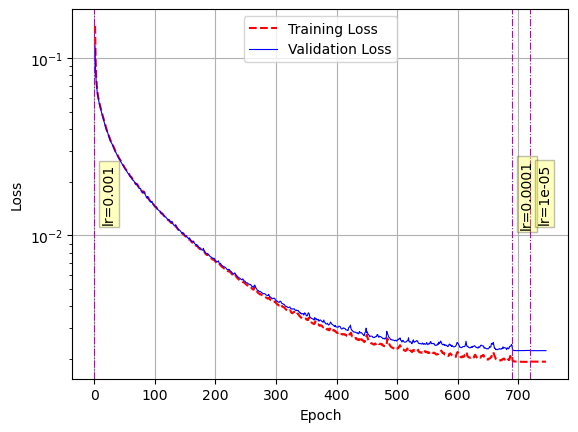

In [33]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


data_idx : 10


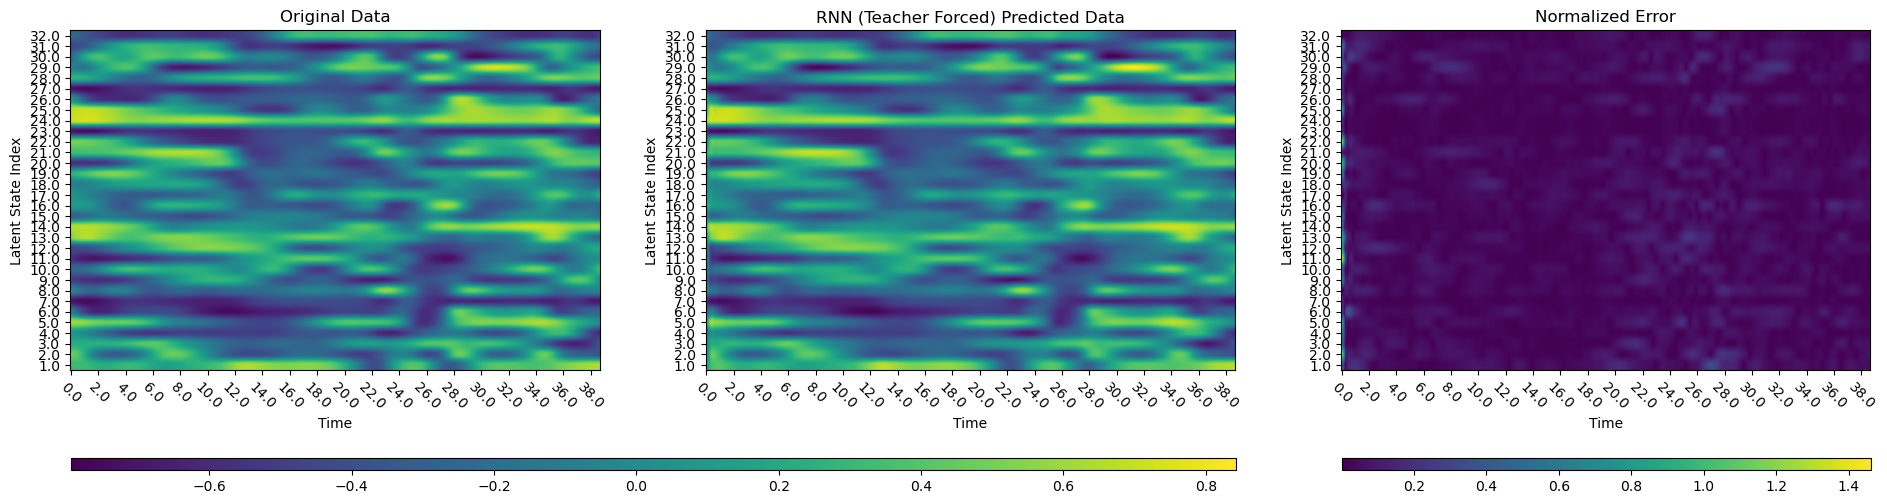

In [34]:
# data_type = 'training'
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_ae,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [35]:
prediction.shape, data_out.shape

((1, 387, 32), (387, 32))